In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

figuresDir = "figuras"
pathlib.Path(figuresDir).mkdir(parents=True, exist_ok=True)

def snake_to_title_case(column_name):
    return column_name.replace("_", " ").title()

In [219]:
# Generar lista de departamentos
depts = []
for dir in os.listdir():
    if dir.startswith("departamento"):
        depts.append(dir)

In [220]:
## Para el anuario 2022, necesito la lista de publicaciones de química del mismo año

# Importar datos de la lista de publicaciones
publicacionesQuimicaDF = pd.read_csv(
    os.path.join(
        "departamento_de_química",
        "publicaciones.csv"
        ),
        index_col=0,
    )

# Exportar lista de dois a un archivo de texto
publicacionesQuimicaDF[publicacionesQuimicaDF['ano'] == 2022]["doi"].to_csv("quimica2022.csv")

In [221]:
## Calcular número de publicaciones por año, por departamento
nPubPorDepartamentoPorAno = pd.DataFrame()
for dept in depts:
    deptPublicacionesDF = pd.read_csv(
        os.path.join(
            dept,
            "publicaciones.csv",
        ),
        index_col=0,
    )
    # Eliminar duplicados por título
    deptPublicacionesDF["titulo_publicacion"] = deptPublicacionesDF["titulo_publicacion"].str.lower()
    deptPublicacionesDF = deptPublicacionesDF.drop_duplicates(
            subset="titulo_publicacion", keep="first"
        )
    deptPublicacionesDF["departamento"] = dept
    nPubPorDepartamentoPorAno = pd.concat(
        [
            nPubPorDepartamentoPorAno,
            deptPublicacionesDF["ano"].value_counts().rename(dept),
        ],
        axis=1,
    )

# Ordenar por año
nPubPorDepartamentoPorAno.sort_index(inplace=True)

# Eliminar último año que no ha terminado
lastYear = nPubPorDepartamentoPorAno.index.max()
nPubPorDepartamentoPorAno.drop([lastYear], inplace=True)

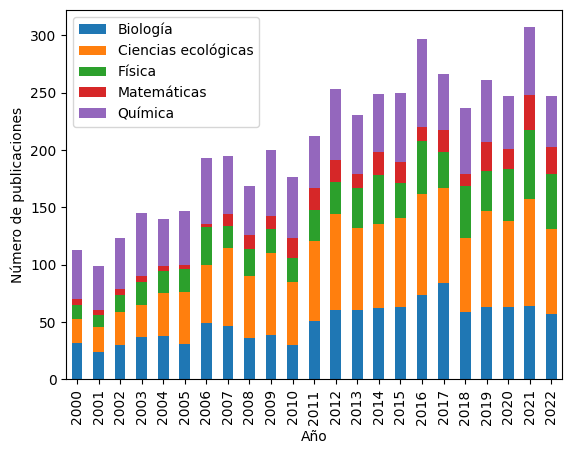

In [222]:
# Nombre de cada departamento
deptArea = {}
for dept in depts:
    deptArea[dept] = snake_to_title_case(dept).split()[-1]

# Corregir nombre de ecologia
deptArea["departamento_de_ciencias_ecológicas"] = "Ciencias ecológicas"

nPubPorDepartamentoPorAno.rename(columns=deptArea).plot(kind='bar', stacked=True)
plt.ylabel("Número de publicaciones")
plt.xlabel("Año")
figname = "nPubPorDepartamentoPorAno"
plt.savefig(f"{figuresDir}/{figname}.png", bbox_inches='tight')
plt.savefig(f"{figuresDir}/{figname}.pdf", bbox_inches='tight')
plt.show()

In [223]:
## Calcular publicaciones por académico

nAcademicos = {}
nPubPorAcademico = {}
for dept in depts:
    academicosDF = pd.read_csv(f"{dept}/academicos.csv", index_col=0)
    nAcademicos[dept] = len(academicosDF)
    nPubPorAcademico[dept] = nPubPorDepartamentoPorAno.loc[2022][dept]/nAcademicos[dept]

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\1696844724.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(deptArea.values(), rotation=50)


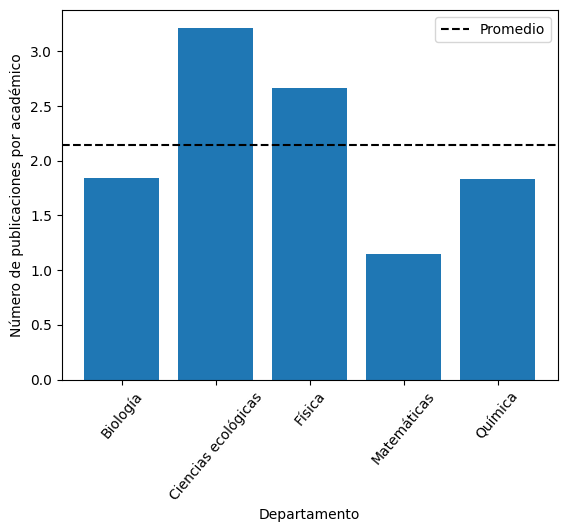

In [224]:
## Graficar el resultado

fig, ax = plt.subplots()
ax.bar(nPubPorAcademico.keys(), nPubPorAcademico.values(), align='center')
ax.set_xticklabels(deptArea.values(), rotation=50)

## calcular el promedio
nPubPorAcademicoAvg = np.mean(list(nPubPorAcademico.values()))
## y graficarlo
ax.axhline(y=nPubPorAcademicoAvg, color='black', linestyle='--', label='Promedio')
plt.xlabel("Departamento")
plt.ylabel("Número de publicaciones por académico")
plt.legend()

figname = "nPubPorAcademico"
plt.savefig(f"{figuresDir}/{figname}.png", bbox_inches='tight')
plt.savefig(f"{figuresDir}/{figname}.pdf", bbox_inches='tight')
plt.show()

In [225]:
def is_WOS(tipo_publicacion):
    if "ISI" in tipo_publicacion:
        return True
    else:
        return False

deptPublicacionesDF["isWOS"] = deptPublicacionesDF["tipo_publicacion"].map(is_WOS)

In [226]:
nonWOSSeries = deptPublicacionesDF[deptPublicacionesDF["isWOS"]==False]["ano"].value_counts().rename("nonWOS")
WOSSeries = deptPublicacionesDF[deptPublicacionesDF["isWOS"]==True]["ano"].value_counts().rename("WOS")

In [227]:
# Graficar publicaciones por año, por departamento, destacando la indexación.

## Primero se debe extraer la infomación

def is_WOS(tipo_publicacion):
    if "ISI" in tipo_publicacion:
        return True
    else:
        return False

# Generar un DataFrame con la información necesaria
nPubPorDepartamentoPorAno = pd.DataFrame()
for dept in depts:
    deptPublicacionesDF = pd.read_csv(
        os.path.join(
            dept,
            "publicaciones.csv",
        ),
        index_col=0,
    )
    # Eliminar duplicados por título
    deptPublicacionesDF["titulo_publicacion"] = deptPublicacionesDF["titulo_publicacion"].str.lower()
    deptPublicacionesDF = deptPublicacionesDF.drop_duplicates(
            subset="titulo_publicacion", keep="first"
        )
    deptPublicacionesDF["departamento"] = dept
    # Clasificar indexación
    deptPublicacionesDF["isWOS"] = deptPublicacionesDF["tipo_publicacion"].map(is_WOS)
    nonWOSSeries = deptPublicacionesDF[deptPublicacionesDF["isWOS"]==False]["ano"].value_counts().rename("nonWOS")
    WOSSeries = deptPublicacionesDF[deptPublicacionesDF["isWOS"]==True]["ano"].value_counts().rename("WOS")
    DFtoAdd = pd.DataFrame([WOSSeries, nonWOSSeries]).T.fillna(0)
    # Añadir el total de publicaciones por año
    DFtoAdd["total"] = DFtoAdd["WOS"]+DFtoAdd["nonWOS"]
    # Etiquetar el departamento
    DFtoAdd["departamento"] = dept
    nPubPorDepartamentoPorAno = pd.concat([nPubPorDepartamentoPorAno, DFtoAdd,])
    
# Eliminar último año que no ha terminado
lastYear = nPubPorDepartamentoPorAno.index.max()
nPubPorDepartamentoPorAno.drop([lastYear], inplace=True)

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\3865040746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDeptDF.sort_index(inplace=True)


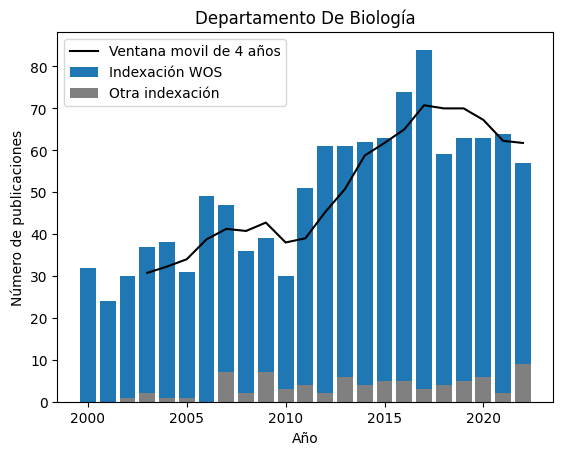

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\3865040746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDeptDF.sort_index(inplace=True)


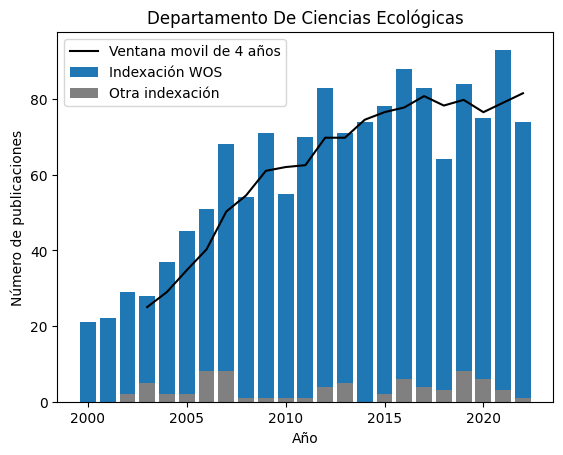

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\3865040746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDeptDF.sort_index(inplace=True)


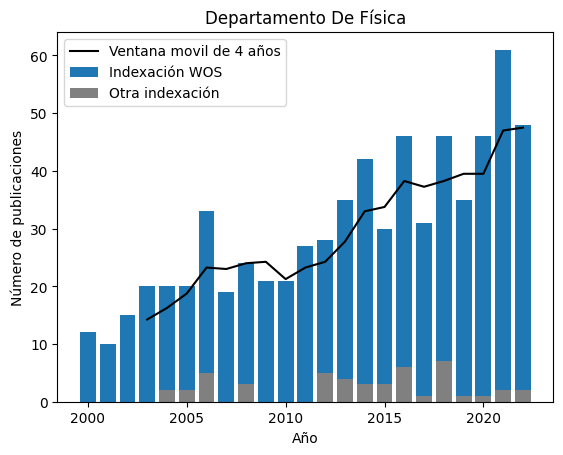

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\3865040746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDeptDF.sort_index(inplace=True)


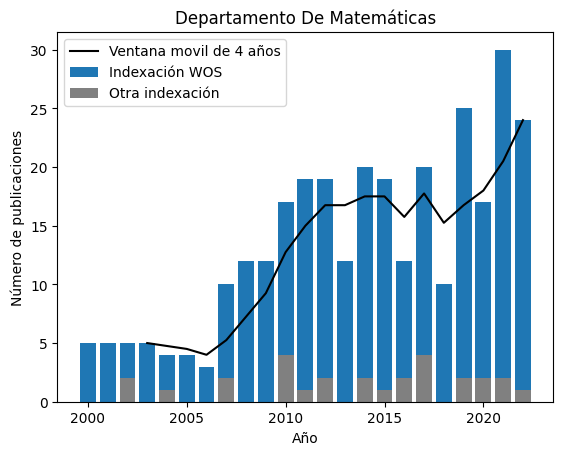

C:\Users\lkeel\AppData\Local\Temp\ipykernel_17384\3865040746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentDeptDF.sort_index(inplace=True)


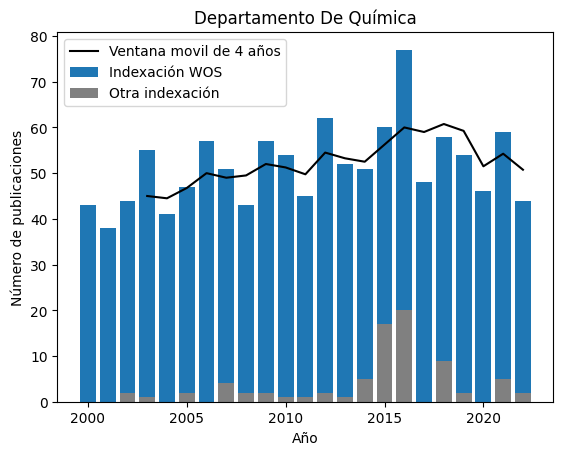

In [228]:
# Gragificar el resultado

for dept in depts:
    currentDeptDF = nPubPorDepartamentoPorAno[nPubPorDepartamentoPorAno["departamento"] == dept]
    currentDeptDF.sort_index(inplace=True)
    fig, ax = plt.subplots()
    ax.bar(currentDeptDF.index, currentDeptDF["WOS"], bottom=currentDeptDF["nonWOS"], color="C0", label="Indexación WOS")
    ax.bar(currentDeptDF.index, currentDeptDF["nonWOS"], color="gray", label="Otra indexación")
    ax.plot(currentDeptDF.index, currentDeptDF["total"].rolling(4).mean(), color="black", label="Ventana movil de 4 años")

    plt.xlabel("Año")
    plt.ylabel("Número de publicaciones")
    plt.legend()
    plt.title(snake_to_title_case(dept))
    figname = f"nPub_{dept}"
    plt.savefig(f"{figuresDir}/{figname}.png", bbox_inches='tight')
    plt.savefig(f"{figuresDir}/{figname}.pdf", bbox_inches='tight')
    plt.show()

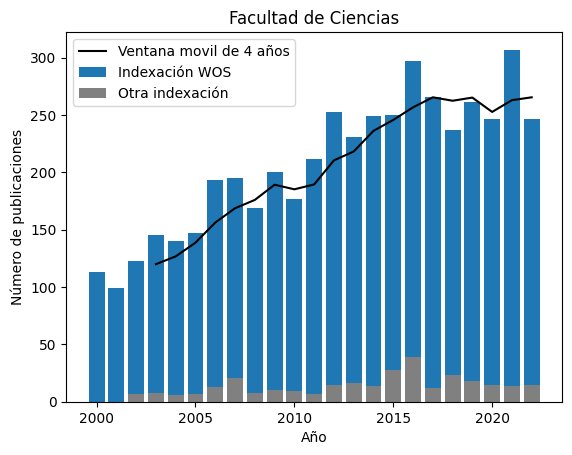

In [229]:
nPubTotalesPorAno = nPubPorDepartamentoPorAno.pivot(columns="departamento").groupby(level=0, axis=1).sum()

fig, ax = plt.subplots()
ax.bar(nPubTotalesPorAno.index, nPubTotalesPorAno["WOS"], bottom=nPubTotalesPorAno["nonWOS"], color="C0", label="Indexación WOS")
ax.bar(nPubTotalesPorAno.index, nPubTotalesPorAno["nonWOS"], color="gray", label="Otra indexación")
ax.plot(nPubTotalesPorAno.index, nPubTotalesPorAno["total"].rolling(4).mean(), color="black", label="Ventana movil de 4 años")

plt.xlabel("Año")
plt.ylabel("Número de publicaciones")
plt.legend()
plt.title("Facultad de Ciencias")

figname = "nPubTotalesPorAno"
plt.savefig(f"{figuresDir}/{figname}.png", bbox_inches='tight')
plt.savefig(f"{figuresDir}/{figname}.pdf", bbox_inches='tight')
plt.show()